# Habituation to weakly non-Gaussian odor backgrounds
Look at a case with three odors. Illustrate how the third moment is important for IBCM to identify odors and converge to specific fixed points. 

## Some notes on the setting
### Saturation function on IBCM neurons
Since the fluctuations are still fast compared to the IBCM neurons, we do not really need saturation functions to prevent numerical divergences (while still using a large time step). Also, the model converges fast enough that we don't need the Law and Cooper, 1994 modification. 

### Background process
We simulate a zero-mean Ornstein-Uhlenbeck process $\tilde{\nu}$, then we set the actual odor concentrations to be $\nu = \nu_0 + \tilde{\nu} + \epsilon \tilde{\nu}^2$. This ensures that the odor concentrations have a third moment of order $\epsilon$. More precisely, we find that if there are no correlations, we can treat each component $\nu_{\gamma}$ as a univariate case, and we then have a third moment of order $\epsilon$, with only lower-order corrections to the second moment and order $\epsilon$ corrections to the desired mean $\nu_0$:

$$ \langle \nu \rangle = \nu_0 + \epsilon \sigma^2 $$
$$ \langle (\nu - \langle \nu \rangle)^2 \rangle = \sigma^2 + 2 \epsilon^2 \sigma^4 $$
$$ \langle (\nu - \langle \nu \rangle)^3 \rangle = 6 \epsilon \sigma^4 + 8 \epsilon^3 \sigma^6 $$

For multiple odors, $\tilde{\nu}$ is a multivariate O-U process as defined in Gardiner's Handbook, and the term $\epsilon \tilde{\nu}^2$ is computed element-wise. But in practice, we only consider independent odors, each can thus be thought of as a scalar O-U process. 

In this notebook, we compare the case where $\epsilon = 0$ (Gaussian background) with the case $\epsilon > 0$. 


## Imports

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os, sys
if ".." not in sys.path:
    sys.path.insert(1, "..")

from modelfcts.ibcm import (
    integrate_inhib_ibcm_network_options,
    ibcm_respond_new_odors,
    compute_mbars_cgammas_cbargammas,
    ibcm_respond_new_odors
)
from modelfcts.ibcm_analytics import (
    fixedpoint_thirdmoment_exact, 
    fixedpoint_thirdmoment_perturbtheory, 
    ibcm_fixedpoint_w_thirdmoment, 
    jacobian_fixedpoint_thirdmoment, 
    ibcm_all_largest_eigenvalues
)
from modelfcts.backgrounds import (
    update_thirdmoment_kinputs, 
    update_ou_kinputs,
    sample_ss_distrib_thirdmoment, 
    sample_background_thirdmoment, 
    generate_odorant
)
from utils.statistics import seed_from_gen
from utils.smoothing_function import (
    moving_average, 
    moving_var
)
from simulfcts.plotting import (
    plot_cbars_gammas_sums, 
    plot_cbars_gamma_series, 
    plot_3d_series, 
    plot_w_matrix, 
    plot_background_norm_inhibition, 
    plot_background_neurons_inhibition, 
)
from simulfcts.analysis import compute_back_reduction_stats
from utils.metrics import l2_norm

### Aesthetic parameters

In [2]:
do_save_plots = False
do_save_outputs = False

#plt.style.use(['dark_background'])
plt.rcParams["figure.figsize"] = (4.5, 3.0)
plt.rcParams["axes.facecolor"] = (1,1,1,0)  # transparent background

# Simulation for Gaussian background

### Analytical fixed point prediction for IBCM model 
**Consider the case of gaussian $\nu_{\alpha}$ and $\rho=0$**

Calculations predicting a $K-2$ dimensional ensemble of fixed points in the subspace spanned by the $K$ background components. If $D > K$, the $D-K$ dimensions not spanned by the odor components have no dynamics happening in them,  since $\frac{d\vec{m}}{dt} \propto \vec{x}(t)$; initial conditions remain unchanged in that space. So, in the full $D$-dimensional space, the fixed points occupy a structure of $D-2$ dimensions, but only $K-2$ of them are not trivial. 
The two constraints satisfied at the fixed points are, in the $\rho = 0$ case, which is just a linear transformation away from the more general case (by diagonalization of the covariance matrix):
$$ \sum_{\alpha} \bar{c}_{\alpha} = 1 $$
$$ \sum_{\alpha} \bar{c}_{\alpha}^2 = \frac{1}{\sigma^2} $$
where
$$ \bar{c}_{i, \alpha} = \vec{m}_{i} \cdot \vec{x}_{\alpha} - \eta \sum_{j \neq i} \vec{m}_j \cdot \vec{x}_{\alpha} $$

Note that the case $\rho \neq 0$ would be qualitatively the same as $\rho = 0$: we could always rewrite the input mixture as a linear combination in the basis of the eigenvectors of the correlation matrix, where there are no correlations between components. Hence, posing $\rho = 0$ to simplify calculations does not reduce the generality of the result. 

In the $\rho \neq 0$, one can derive the fixed point by transforming to normal coordinates, applying those two constraints on the new odor components, and transforming back. I did not take the time to do it explicity. Here, for comparison with the calculation, I set $\rho = 0$ and compare to analytical predictions. 

In [3]:
# Initialize common simulation parameters
n_dimensions = 25  # Half the real number for faster simulations
n_components = 3  # Number of background odors

inhib_rates = [0.00025, 0.00005]  # alpha, beta

# Simulation duration
duration = 240000.0
deltat = 1.0
skp = 10

# Common model options
activ_function = "identity"  #"ReLU"

# Background process
update_fct = update_ou_kinputs

# Choose randomly generated background vectors
rgen_meta = np.random.default_rng(seed=0x2e6e8080973281c2c9d1ca57e5b90996)
back_type = "symmetric"  # "random"
if back_type == "random":
    back_components = np.zeros([n_components, n_dimensions])
    for i in range(n_components):
        back_components[i] = generate_odorant(n_dimensions, rgen_meta, lambda_in=0.1)
    back_components = back_components / l2_norm(back_components).reshape(-1, 1)

# Choose three LI vectors in (+, +, +) octant
elif back_type == "symmetric":
    back_components = 0.1*np.ones([n_components, n_dimensions])
    for i in range(n_components):
        if i < n_dimensions:
            back_components[i, i] = 0.8
        else:
            back_components[i, i % n_dimensions] = 0.8 - i
        # Normalize
        back_components[i] = back_components[i] / np.sqrt(np.sum(back_components[i]**2))
else:
    raise ValueError('back_type should be either "symmetric" or "random"')


# Seed for background simulation, to make sure all models are the same
simul_seed = seed_from_gen(rgen_meta)

# Initial background vector and initial nu values
averages_nu = np.ones(n_components) / np.sqrt(n_components)
init_nu = np.zeros(n_components)
init_bkvec = averages_nu.dot(back_components)

## Compute the matrices in the Ornstein-Uhlenbeck update equation
# Update matrix for the mean term: 
# Exponential decay with time scale tau_nu over time deltat
tau_nu = 2.0  # Fluctuation time scale of the background nu_gammas (same for all)
update_mat_A = np.identity(n_components)*np.exp(-deltat/tau_nu)

# Steady-state covariance matrix
sigma2 = 0.09
correl_rho = 0.0
steady_covmat = correl_rho * sigma2 * np.ones([n_components, n_components])  # Off-diagonals: rho
steady_covmat[np.eye(n_components, dtype=bool)] = sigma2  # diagonal: ones

# Cholesky decomposition of steady_covmat gives sqrt(tau/2) B
# Update matrix for the noise term: \sqrt(tau/2(1 - exp(-2*deltat/tau))) B
psi_mat = np.linalg.cholesky(steady_covmat)
update_mat_B = np.sqrt(1.0 - np.exp(-2.0*deltat/tau_nu)) * psi_mat

back_params = [update_mat_A, update_mat_B, back_components, averages_nu]
# nus are first in the list of initial background params
init_back_list = [init_nu, init_bkvec]

### IBCM habituation simulation for Gaussian background

In [4]:
# IBCM model parameters
n_i_ibcm = 32  # Number of inhibitory neurons for IBCM case

# Model rates
learnrate_ibcm = 0.0025  # 0.000001 = 1e-6
tau_avg_ibcm = 150
coupling_eta_ibcm = 0.5/n_i_ibcm
decay_relative_ibcm = 0.0  # dummy
k_c2bar_avg = 1.0  # dummy
ssat_ibcm = 100.0 # dummy
lambd_ibcm = 1.0
ibcm_rates = [
    learnrate_ibcm, 
    tau_avg_ibcm, 
    coupling_eta_ibcm, 
    lambd_ibcm,
    ssat_ibcm, 
    k_c2bar_avg,
    decay_relative_ibcm
]
ibcm_options = {
    "activ_fct": activ_function, 
    "saturation": "linear", 
    "variant": "intrator", 
    "decay": False
}

# Initial synaptic weights: small positive noise
init_synapses_ibcm = 0.2*rgen_meta.standard_normal(size=[n_i_ibcm, n_dimensions])

In [5]:
# Run the IBCM simulations
sim_results = integrate_inhib_ibcm_network_options(
                init_synapses_ibcm, update_fct, init_back_list, 
                ibcm_rates, inhib_rates, back_params, duration, 
                deltat, seed=simul_seed, noisetype="normal",  
                skp=skp, **ibcm_options
)

(tser_ibcm, 
 nuser_ibcm, 
 bkvecser_ibcm, 
 mser_ibcm, 
 cbarser_ibcm, 
 thetaser_ibcm,
 wser_ibcm, 
 yser_ibcm) = sim_results

### 3D plot for Gaussian inputs
We just want to illustrate $M$ trajectories here, but do make a few check plots below as well. 

In [6]:
# Calculate cgammas_bar and mbars
# Dot products \bar{c}_{\gamma} = \bar{\vec{m}} \cdot \vec{x}_{\gamma}
mbarser_ibcm, c_gammas, cbars_gamma = compute_mbars_cgammas_cbargammas(
                                    mser_ibcm, coupling_eta_ibcm, back_components)

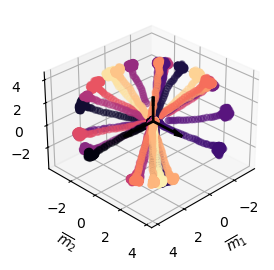

In [7]:
fig, ax = plot_3d_series(mbarser_ibcm, dim_idx=[0, 1, 2], transient=1000, skp=100)

# Annotate with vectors representing the odor components
orig = np.zeros([n_components, n_components])
xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
scale = 3
vecs = back_components.copy()
for i in range(n_components):
    vecs[i] = back_components[i] / np.sqrt(np.sum(back_components[i]**2)) * scale
ax.quiver(*orig, *(vecs[:, :3].T), color="k", lw=2.0)
ax.view_init(azim=45, elev=30)
ax.set(xlabel=r"$\overline{m}_1$", ylabel=r"$\overline{m}_2$", zlabel=r"$\overline{m}_3$")
if do_save_plots:
    fig.savefig(os.path.join("..", "figures", 
        "three_odors", "mbar_dynamics_ibcm_3odors_gaussian.pdf"), transparent=True)
plt.show()
plt.close()

In [8]:
# Calculate cgammas_bar and mbars
transient = 100000 // skp
# Dot products \bar{c}_{\gamma} = \bar{\vec{m}} \cdot \vec{x}_{\gamma}
mbarser, c_gammas, cbars_gamma = compute_mbars_cgammas_cbargammas(
                                    mser_ibcm, coupling_eta_ibcm, back_components)
sums_cbars_gamma = np.sum(cbars_gamma, axis=2)
sums_cbars_gamma2 = np.sum(cbars_gamma*cbars_gamma, axis=2)

# Analytical prediction, exact: need moments of nu. 
variance_nu2 = sigma2
mean_nu2 = averages_nu[0]

# Compare to numerical values.
fullnuser2 = averages_nu.reshape(1, -1) + nuser_ibcm
mean_nu2_sim = np.mean(fullnuser2)  # all odors i.i.d., can average over them. 
variance_nu2_sim = np.mean((fullnuser2 - mean_nu2_sim)**2)
thirdmoment2_sim = np.mean((fullnuser2 - mean_nu2_sim)**3)
moments_conc2 = [mean_nu2, variance_nu2, 0.0]

# Predict the saddle point where all h_gammas are equal, I suspect the model goes there first. 
saddle_h = fixedpoint_thirdmoment_exact(moments_conc2, n_components, 0, lambd=lambd_ibcm)[0]
print(saddle_h)

specif_gammas = np.argmax(np.mean(cbars_gamma[transient:], axis=0), axis=1)
print(specif_gammas)

0.6171490967686428
[0 1 0 2 1 1 1 2 1 0 2 2 0 2 0 0 2 0 2 0 2 1 2 0 2 2 1 1 2 2 2 1]


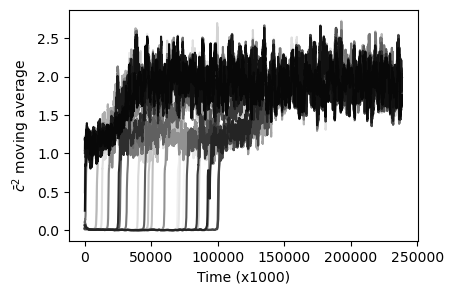

In [9]:
# Plot the cbar2_avg term throughout
cbar2_avg_ser = moving_average(cbarser_ibcm*cbarser_ibcm, kernelsize=tau_avg_ibcm)
neurons_cmap = sns.color_palette("Greys", n_colors=n_i_ibcm)
fig, ax = plt.subplots()
for i in range(n_i_ibcm):
    ax.plot(tser_ibcm[:-tau_avg_ibcm], cbar2_avg_ser[:-tau_avg_ibcm, i], 
            color=neurons_cmap[i])
ax.set(xlabel="Time (x1000)", ylabel=r"$\bar{c}^2$ moving average")
plt.show()
plt.close()

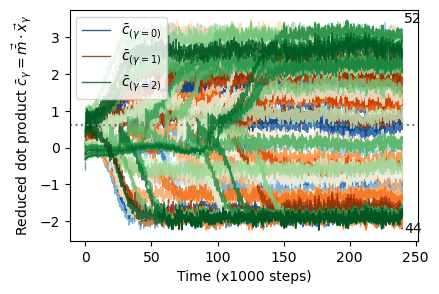

In [10]:
fig , ax, _ = plot_cbars_gamma_series(tser_ibcm, cbars_gamma, 
                        skp=10, transient=80000 // skp)
# Compare to exact analytical fixed point solution
ax.axhline(saddle_h, ls=":", color="grey", 
           label="Saddle point")
plt.show()
plt.close()

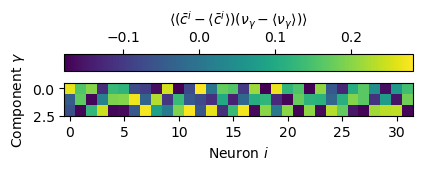

In [11]:
# Correlation between nu's and c's, see if some neurons are specific to odors
# Each neuron turns out to correlate its response to  one concentration
# that means it is specific to that odor. 
cbarser_norm_centered = cbarser_ibcm - np.mean(cbarser_ibcm[transient:], axis=0)
conc_ser_centered = fullnuser2 - mean_nu2
correl_c_nu = np.mean(cbarser_norm_centered[transient:, :, None] 
                      * conc_ser_centered[transient:, None, :], axis=0)

fig, ax = plt.subplots()
img = ax.imshow(correl_c_nu.T)
ax.set(ylabel=r"Component $\gamma$", xlabel=r"Neuron $i$")
fig.colorbar(img, label=r"$\langle (\bar{c}^i - \langle \bar{c}^i \rangle)"
             r"(\nu_{\gamma} - \langle \nu_{\gamma} \rangle) \rangle$", 
            location="top")
plt.show()
plt.close()

#### Habituation
The IBCM network still performs habituation despite not having odors to become specific to: similar to BioPCA in this case. 

Mean activity norm reduced to 2.6 % of input
Standard deviation of activity norm reduced to 4.9 % of input


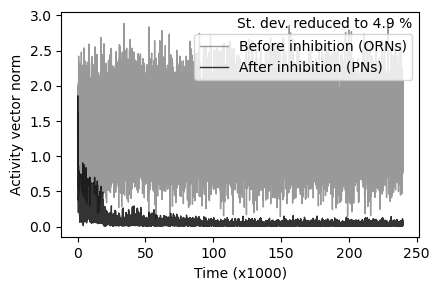

In [12]:
fig, ax, bknorm_ser, ynorm_ser = plot_background_norm_inhibition(
                                tser_ibcm, bkvecser_ibcm, yser_ibcm, skp=1)

# Compute noise reduction factor, annotate
transient = 100000 // skp
norm_stats = compute_back_reduction_stats(bknorm_ser, ynorm_ser, trans=transient)

print("Mean activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['avg_reduction'] * 100))
print("Standard deviation of activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['std_reduction'] * 100))
ax.annotate("St. dev. reduced to {:.1f} %".format(norm_stats['std_reduction'] * 100), 
           xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top")

ax.legend(loc="center right", bbox_to_anchor=(1.0, 0.8))
fig.tight_layout()
plt.show()
plt.close()

# Simulation for non-Gaussian background
Use the same parameters and background odors as before, but now introduce a third moment with $\epsilon > 0$. 

In [13]:
update_fct = update_thirdmoment_kinputs
epsilon_nu = 0.2
back_params3 = back_params + [epsilon_nu]

In [14]:
# Run the IBCM simulations
sim_results = integrate_inhib_ibcm_network_options(
                init_synapses_ibcm, update_fct, init_back_list, 
                ibcm_rates, inhib_rates, back_params3, duration, 
                deltat, seed=simul_seed, noisetype="normal",  
                skp=skp, **ibcm_options
)

(tser_ibcm3, 
 nuser_ibcm3, 
 bkvecser_ibcm3, 
 mser_ibcm3, 
 cbarser_ibcm3, 
 thetaser_ibcm3,
 wser_ibcm3, 
 yser_ibcm3) = sim_results

In [15]:
# Calculate cgammas_bar and mbars
# Dot products \bar{c}_{\gamma} = \bar{\vec{m}} \cdot \vec{x}_{\gamma}
mbarser3, c_gammas3, cbars_gamma3 = compute_mbars_cgammas_cbargammas(
                                    mser_ibcm3, coupling_eta_ibcm, back_components)
sums_cbars_gamma3 = np.sum(cbars_gamma3, axis=2)
sums_cbars_gamma23 = np.sum(cbars_gamma3*cbars_gamma3, axis=2)

# Analytical prediction, exact: need moments of nu. 
variance_nu3 = sigma2 + 2*(epsilon_nu*sigma2)**2
mean_nu3 = averages_nu[0] + epsilon_nu*sigma2
thirdmoment = 6*epsilon_nu*sigma2**2 + 8*(epsilon_nu*sigma2)**3

# Compare to numerical values.
fullnuser3 = averages_nu.reshape(1, -1) + nuser_ibcm3 + epsilon_nu*nuser_ibcm3**2
mean_nu3_sim = np.mean(fullnuser3)  # all odors i.i.d., can average over them. 
variance_nu3_sim = np.mean((fullnuser3 - mean_nu3_sim)**2)
thirdmoment_sim = np.mean((fullnuser3 - mean_nu3_sim)**3)
moments_conc3 = [mean_nu3, variance_nu3, thirdmoment]

# Analytical prediction
hs_hn = fixedpoint_thirdmoment_exact(moments_conc3, 1, n_components-1, lambd=lambd_ibcm)
hs_hn = hs_hn[:2]
h_specif, h_nonspecif = hs_hn

# Also check the saddle point where all h_gammas are equal, I suspect the model goes there first. 
saddle_h3 = fixedpoint_thirdmoment_exact(moments_conc3, n_components, 0, lambd=lambd_ibcm)[0]
print(saddle_h3)

# Count how many dot products are at each possible value. Use cbar = 1.0 as a split. 
split_val = 1.0
cbars_gamma_mean3 = np.mean(cbars_gamma3[transient:], axis=0)
cgammas_bar_counts3 = {"above": int(np.sum(cbars_gamma_mean3.flatten() > split_val)), 
                      "below": int(np.sum(cbars_gamma_mean3.flatten() <= split_val))}
print(cgammas_bar_counts3)

specif_gammas3 = np.argmax(np.mean(cbars_gamma3[transient:], axis=0), axis=1)
print(specif_gammas3)

# Analytical W
analytical_w = ibcm_fixedpoint_w_thirdmoment(inhib_rates, moments_conc3, back_components, hs_hn, specif_gammas3)

0.5994108426138831
{'above': 32, 'below': 64}
[0 1 0 2 1 1 1 2 1 0 1 2 0 2 0 0 2 0 2 0 2 0 2 1 0 2 1 1 0 2 2 0]


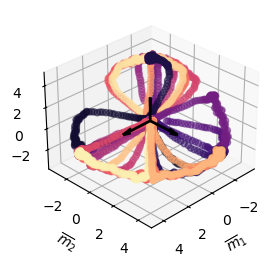

In [16]:
fig, ax = plot_3d_series(mbarser3, dim_idx=[0, 1, 2], transient=1000, skp=100)

# Annotate with vectors representing the odor components
orig = np.zeros([n_components, n_components])
xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
scale = 3
vecs = back_components.copy()
for i in range(n_components):
    vecs[i] = back_components[i] / np.sqrt(np.sum(back_components[i]**2)) * scale
ax.quiver(*orig, *(vecs[:, :3].T), color="k", lw=2.0)
ax.view_init(azim=45, elev=30)
ax.set(xlabel=r"$\overline{m}_1$", ylabel=r"$\overline{m}_2$", zlabel=r"$\overline{m}_3$")
if do_save_plots:
    fig.savefig(os.path.join("..", "figures", "three_odors", 
        "mbar_dynamics_ibcm_3odors_non-gaussian.pdf"), transparent=True)
plt.show()
plt.close()

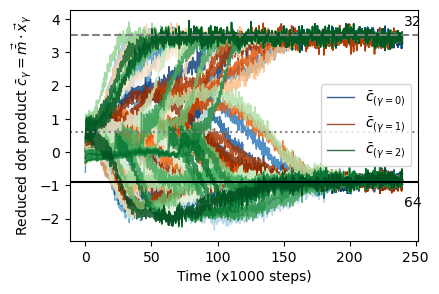

In [17]:
fig , ax, _ = plot_cbars_gamma_series(tser_ibcm3, cbars_gamma3, 
                        skp=10, transient=80000 // skp)
# Compare to exact analytical fixed point solution
ax.axhline(h_specif, ls="--", color="grey", 
           label=r"Analytical $\bar{c}_{\gamma=\mathrm{specific}}$")
ax.axhline(h_nonspecif, ls="-", color="k", 
           label=r"Analytical $\bar{c}_{\gamma=\mathrm{non}}$")
ax.axhline(saddle_h3, ls=":", color="grey", 
           label="Saddle point")
plt.show()
plt.close()

Mean activity norm reduced to 3.1 % of input
Standard deviation of activity norm reduced to 6.4 % of input


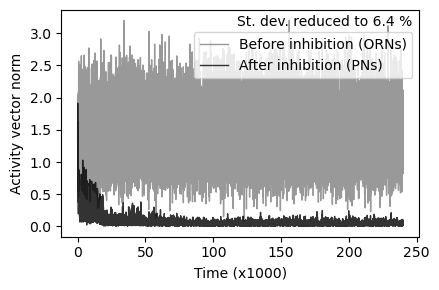

In [18]:
fig, ax, bknorm_ser, ynorm_ser = plot_background_norm_inhibition(
                                tser_ibcm3, bkvecser_ibcm3, yser_ibcm3, skp=1)

# Compute noise reduction factor, annotate
transient = 100000 // skp
norm_stats = compute_back_reduction_stats(bknorm_ser, ynorm_ser, trans=transient)

print("Mean activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['avg_reduction'] * 100))
print("Standard deviation of activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['std_reduction'] * 100))
ax.annotate("St. dev. reduced to {:.1f} %".format(norm_stats['std_reduction'] * 100), 
           xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top")

ax.legend(loc="center right", bbox_to_anchor=(1.0, 0.8))
fig.tight_layout()
plt.show()
plt.close()

# Save outputs for final plotting

In [20]:
fname = os.path.join("..", "results", "for_plots", 
                     "importance_thirdmoment_examples.npz")
save_skp = 10
if do_save_outputs:
    np.savez_compressed(
        fname, 
        hgammaser2=cbars_gamma[::save_skp], 
        hgammaser3=cbars_gamma3[::save_skp], 
        # Save only a few points and only the first 
        # three dimensions that we will plot
        mbarser2=mbarser_ibcm[::save_skp*10, :, :3], 
        mbarser3=mbarser3[::save_skp*10, :, :3], 
        back_components=back_components, 
        tser=tser_ibcm3[::save_skp], 
        h2=np.asarray([saddle_h]), 
        h3=np.asarray([h_specif, h_nonspecif, saddle_h3]), 
        moments2=np.asarray(moments_conc2), 
        moments3=np.asarray(moments_conc3)
    )